In [2]:
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib

In [3]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

df = pd.read_csv("Joules_of_Siam_Data - Dataset_Strech.csv")
df.head()

,Year,Month,Population,Temperature,CPI,Peak
0,2022,12,66.090000,26.300000,106.470000,27124.7
1,2022,11,66.083333,26.249167,106.470000,27832.7
2,2022,10,66.076667,26.198333,106.470000,27041.9
3,2022,9,66.070000,26.147500,106.470000,27808.0
4,2022,8,66.063333,26.096667,108.503333,28951.8


In [5]:
df.shape

(252, 6)

In [6]:
df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)

In [7]:
X = df[['Date','Peak']]
X.head()

,Date,Peak
0,2022-12,27124.7
1,2022-11,27832.7
2,2022-10,27041.9
3,2022-09,27808.0
4,2022-08,28951.8


In [8]:
X = X.iloc[::-1]
X = X.reset_index(drop=False)
X.drop(columns = ['index'], inplace=True)
X.set_index('Date', inplace=True)
X.head()

,Peak
Date,
2002-01,14552.5
2002-02,15260.8
2002-03,16485.3
2002-04,16681.1
2002-05,16293.1


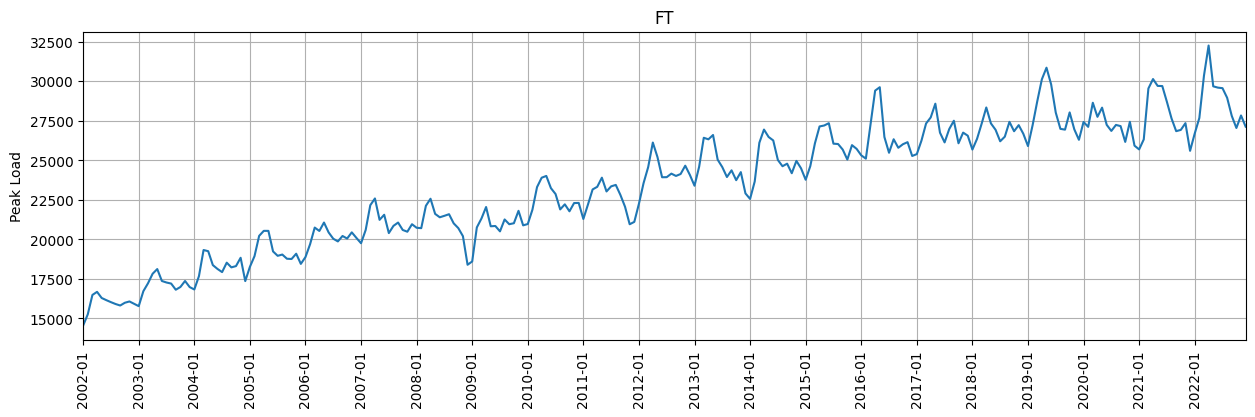

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.xticks(X.index[::12], rotation=90)
plt.show()

In [10]:
y = X.Peak.values.astype(float)

test_size = 24
window_size = 24

train_set = y[:-test_size]
test_set  = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 228
Test:  24


In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 14552.5
First item, scaled: [-1.]


In [12]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [13]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 204


In [14]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(101)
model = LSTMnetwork().to(device)
model

cuda


LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training 

In [16]:
from tqdm import tqdm
epochs = 5000

for i in tqdm(range(epochs)):
    for seq, y_train in train_data:
        
        seq = seq.to(device)
        y_train = y_train.to(device)
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        
        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    if (i+1) % 500 == 0:
        # OPTIONAL print statement
        print(f'{i+1} of {epochs} epochs completed')

 10%|█         | 500/5000 [05:25<46:18,  1.62it/s]

500 of 5000 epochs completed


 20%|██        | 1000/5000 [10:53<45:10,  1.48it/s]

1000 of 5000 epochs completed


 30%|███       | 1500/5000 [16:20<37:52,  1.54it/s]

1500 of 5000 epochs completed


 40%|████      | 2000/5000 [21:46<32:55,  1.52it/s]

2000 of 5000 epochs completed


 50%|█████     | 2500/5000 [27:16<27:57,  1.49it/s]

2500 of 5000 epochs completed


 60%|██████    | 3000/5000 [32:45<21:57,  1.52it/s]

3000 of 5000 epochs completed


 70%|███████   | 3500/5000 [38:05<14:30,  1.72it/s]

3500 of 5000 epochs completed


 80%|████████  | 4000/5000 [43:14<10:05,  1.65it/s]

4000 of 5000 epochs completed


 90%|█████████ | 4500/5000 [48:22<05:04,  1.64it/s]

4500 of 5000 epochs completed


100%|██████████| 5000/5000 [53:32<00:00,  1.56it/s]

5000 of 5000 epochs completed


## Testing 

In [17]:
future = 24 #months
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future): #future
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        preds.append(model(seq).item())
        
# preds[window_size:]

In [18]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
# true_predictions = true_predictions.astype(str).tolist()

In [19]:
true_predictions = true_predictions.reshape(-1)

In [20]:
day = np.arange('2021-01', '2023-01', dtype='datetime64[M]') #.astype('datetime64[D]')
day = day.astype(str).tolist()

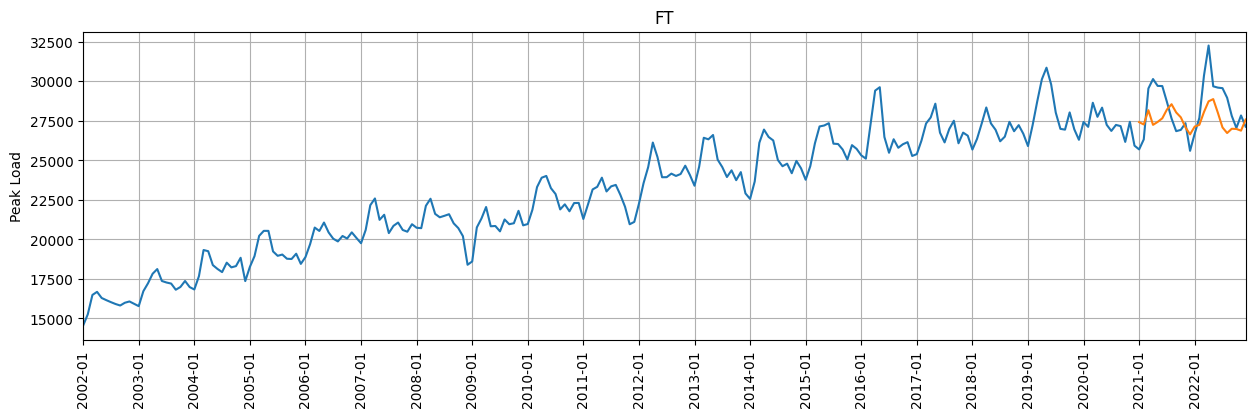

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.plot(day, true_predictions)
plt.xticks(X.index[::12], rotation=90)
plt.show()

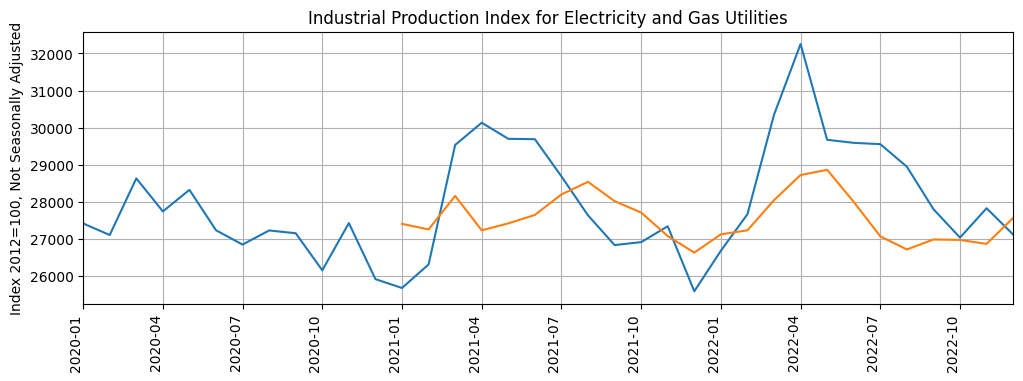

In [22]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(X['Peak']['2020-01':])
plt.plot(day, true_predictions)
plt.xticks(X['Peak']['2020-01':].index[::3], rotation=90)
plt.show()

In [23]:
test_set

array([25686.2, 26318.8, 29536.8, 30135.3, 29702. , 29692.1, 28690.5,
       27642.1, 26841.2, 26920.4, 27346.9, 25596.9, 26688.4, 27672.5,
       30349. , 32254.5, 29675.3, 29593.6, 29558.1, 28951.8, 27808. ,
       27041.9, 27832.7, 27124.7])

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

MSE  = mean_squared_error(test_set, true_predictions)
RMSE = math.sqrt(MSE)
MAE  = mean_absolute_error(test_set, true_predictions)

MSE, RMSE, MAE

(2580443.284516133, 1606.3758229368782, 1334.171057667025)

In [25]:
T_RMSE = RMSE/(np.max(test_set) + np.min(test_set))
T_RMSE

0.02776727655574244

## Inference 

In [26]:
future = 120 #months
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future): #future
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        preds.append(model(seq).item())
        
# preds[window_size:]

In [27]:
true_predictions = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1, 1))
# true_predictions = true_predictions.astype(str).tolist()

In [28]:
true_predictions = true_predictions.reshape(-1)
true_predictions.shape

(120,)

In [29]:
day = np.arange('2021-01', '2031-01', dtype='datetime64[M]') #.astype('datetime64[D]')
day = day.astype(str).tolist()
len(day)

120

In [30]:
day[::12]

['2021-01',
 '2022-01',
 '2023-01',
 '2024-01',
 '2025-01',
 '2026-01',
 '2027-01',
 '2028-01',
 '2029-01',
 '2030-01']

In [31]:
total = X.index[::12].values.tolist() + day[::12]

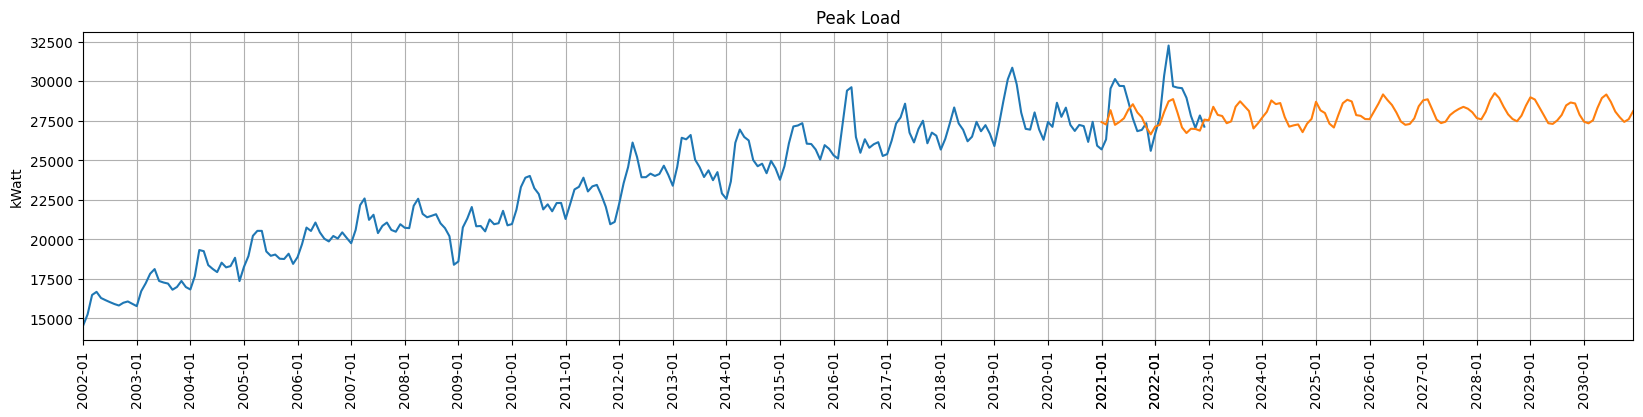

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.title('Peak Load')
plt.ylabel('kWatt')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.plot(day, true_predictions)
plt.xticks(total, rotation=90)
plt.show()

In [33]:
df_peak = pd.DataFrame({"Date":day, "Peak":true_predictions})
df_peak.set_index("Date",inplace=True)
df_peak

,Peak
Date,
2021-01,27412.777862
2021-02,27262.369235
2021-03,28164.896778
2021-04,27238.457737
2021-05,27425.539308
...,...
2030-08,28078.517394
2030-09,27720.160684
2030-10,27426.617295


In [34]:
df_peak.to_csv('Predicting_Peak_2021_2030.csv', index=True)